In [1]:
import pandas as pd
import numpy as np
from textblob import TextBlob
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from datetime import datetime
import seaborn as sns

# Load datasets with explicit date parsing
stock_df = pd.read_csv('data/AMZN_historical_data.csv')
news_df = pd.read_csv('data/raw_analyst_ratings_1.csv')
# Set datetime index for stock data


# Display basic information and the first few rows of each dataset
stock_df_info = stock_df.info()
news_df_info = news_df.info()

# Step 1: Date Alignment


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6846 entries, 0 to 6845
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          6846 non-null   object 
 1   Open          6846 non-null   float64
 2   High          6846 non-null   float64
 3   Low           6846 non-null   float64
 4   Close         6846 non-null   float64
 5   Adj Close     6846 non-null   float64
 6   Volume        6846 non-null   int64  
 7   Dividends     6846 non-null   float64
 8   Stock Splits  6846 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 481.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4580 entries, 0 to 4579
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  4580 non-null   int64  
 1   headline    4580 non-null   object 
 2   url         4580 non-null   object 
 3   publisher   4580 non-null   object 
 4   

In [2]:
stock_df_head = stock_df.head()
news_df_head = news_df.head()

stock_df_info, stock_df_head, news_df_info, news_df_head
# Step 1: Normalize Dates
news_df['date'] = pd.to_datetime(news_df['date'], errors='coerce').dt.date
stock_df['date'] = pd.to_datetime(stock_df['Date'], errors='coerce').dt.date
# Step 2: Perform Sentiment Analysis using TextBlob

news_df['sentiment_score'] = news_df['headline'].astype(str).apply(lambda text: TextBlob(text).sentiment.polarity)

# Step 3: Aggregate Sentiment by Date
daily_sentiment = news_df.groupby('date')['sentiment_score'].mean().reset_index()
daily_sentiment.rename(columns={'date': 'Date', 'sentiment_score': 'avg_sentiment'}, inplace=True)



# Daily returns from adjusted close
stock_df.sort_values('Date', inplace=True)
stock_df['daily_return'] = stock_df['Adj Close'].pct_change()

In [3]:
# Merge on date
merged_df = pd.merge(stock_df, daily_sentiment, on='Date', how='inner')

# Correlation

correlation = merged_df['daily_return'].corr(merged_df['avg_sentiment'])
print("Correlation between daily return and average sentiment:", correlation)


Correlation between daily return and average sentiment: nan


In [4]:
 # Visualize the Correlation

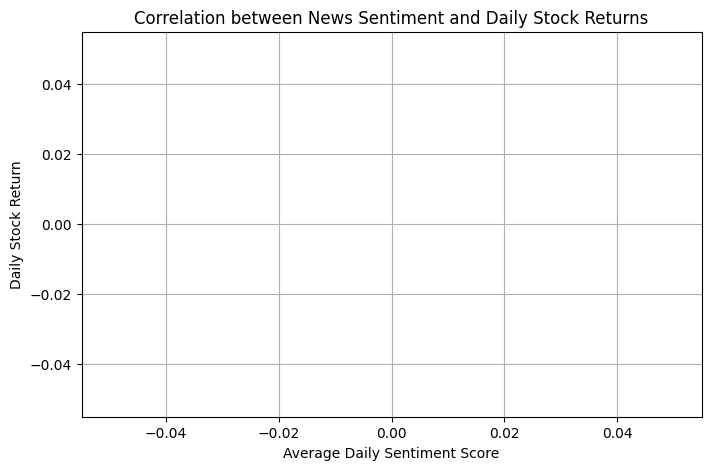

In [5]:
# Scatterplot of sentiment vs return
plt.figure(figsize=(8, 5))
sns.scatterplot(x='avg_sentiment', y='daily_return', data=merged_df)
plt.title('Correlation between News Sentiment and Daily Stock Returns')
plt.xlabel('Average Daily Sentiment Score')
plt.ylabel('Daily Stock Return')
plt.grid(True)
plt.show()

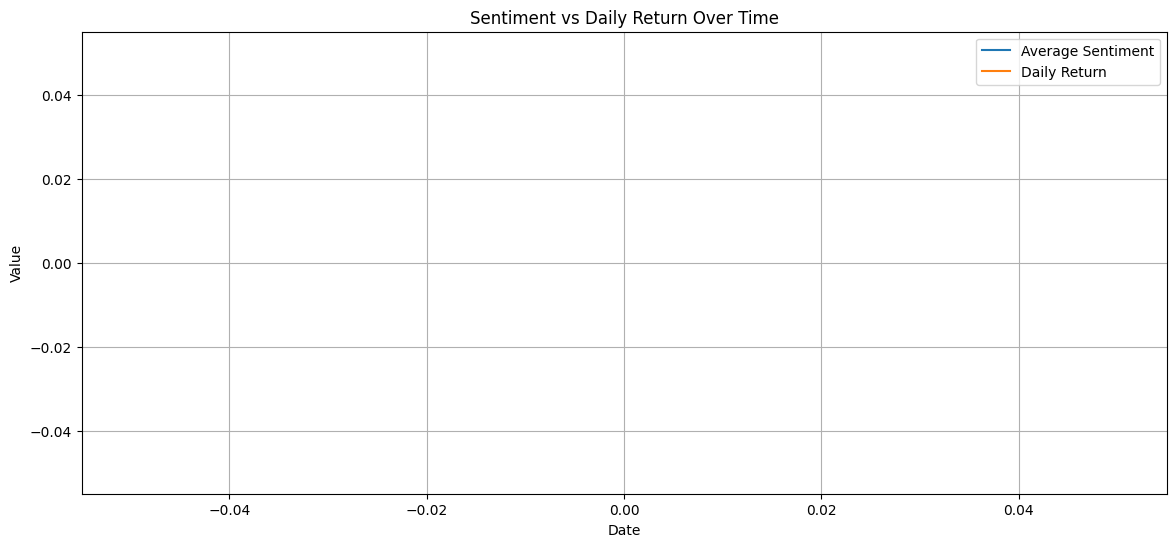

In [6]:
# Time Series Plot
plt.figure(figsize=(14, 6))
plt.plot(merged_df['Date'], merged_df['avg_sentiment'], label='Average Sentiment')
plt.plot(merged_df['Date'], merged_df['daily_return'], label='Daily Return')
plt.title('Sentiment vs Daily Return Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

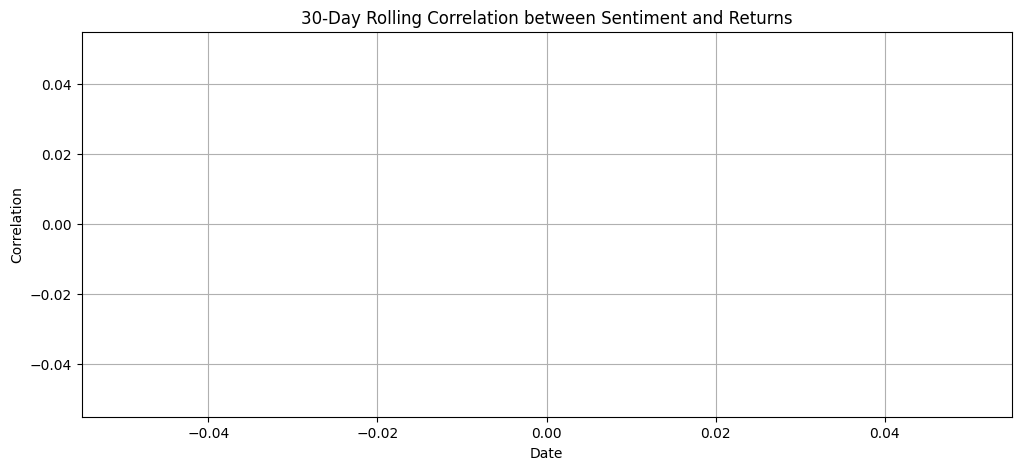

In [7]:
rolling_corr = merged_df['avg_sentiment'].rolling(window=30).corr(merged_df['daily_return'])

plt.figure(figsize=(12, 5))
plt.plot(merged_df['Date'], rolling_corr)
plt.title('30-Day Rolling Correlation between Sentiment and Returns')
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.grid(True)
plt.show()


In [8]:
# 📌 KPIs
coverage = len(merged_df) / len(stock_df) * 100
print(f"Sentiment Coverage: {coverage:.2f}%")


Sentiment Coverage: 0.00%


In [9]:
print("Top 3 Positive Sentiment Days:")
print(merged_df.nlargest(3, 'avg_sentiment')[['Date', 'avg_sentiment', 'daily_return']])

print("Top 3 Negative Sentiment Days:")
print(merged_df.nsmallest(3, 'avg_sentiment')[['Date', 'avg_sentiment', 'daily_return']])


Top 3 Positive Sentiment Days:
Empty DataFrame
Columns: [Date, avg_sentiment, daily_return]
Index: []
Top 3 Negative Sentiment Days:
Empty DataFrame
Columns: [Date, avg_sentiment, daily_return]
Index: []


In [10]:
# Optional: Save output
merged_df.to_csv('merged_sentiment_returns.csv', index=False)